# Electrolyte Solutions using the _Primitive Model_

In this notebook we explore the _primitive model_ for modelling electrolyte solutions. The solvent, here water, is treated as a dielectric continuum, while ions are hard, charged spheres. The excess chemical potential, $\mu^{ex}$ is calculated using the Widom insertion method, based on linear response.
For each Widom insertion, a neutral _pair_ of ions is inserted and removed. The location of the inserted ions is random inside the box, and the test energy includes the interaction between them, as well as with all other particles in the box.

The Notebook requires that the Monte Carlo simulation program [_Faunus_](https://github.com/mlund/faunus) is installed with e.g. `conda install faunus`.

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import N_A
import os
import stat
import json

In [2]:
def make_input(path: str, N: int, L: float, sigma: tuple, steps: int):
    content = f"""#!/usr/bin/env yason.py
temperature: 298.15
random:   {{seed: fixed}}
geometry: {{type: cuboid, length: {L} }}
mcloop:   {{macro: 10, micro: {steps} }}
atomlist:
    - Na+: {{q: 1.0, sigma: {sigma[0]}, dp: 20}}
    - Cl-: {{q: -1.0, sigma: {sigma[1]}, dp: 20}}
moleculelist:
    - sodium:   {{atoms: [Na+], atomic: true}}
    - chloride: {{atoms: [Cl-], atomic: true}}
    # This is a "ghost" salt used for Widom insertion only
    - NaCl: {{atoms: [Na+, Cl-], atomic: true}}
insertmolecules:
    - sodium:   {{N: {N}}}
    - chloride: {{N: {N}}}
    # The ghost salt is not in the box, but kept inactive
    - NaCl: {{N: 1, inactive: 1}}
energy:
    # "pm" = primitive model, e.g Coulomb + Hard
    - nonbonded_pm:
        coulomb: {{epsr: 80.0}}
moves:
    - transrot: {{molecule: sodium, repeat: {N}}}
    - transrot: {{molecule: chloride, repeat: {N}}}
analysis:
    - systemenergy: {{file: energy.dat, nstep: 10}}
    - widom: {{molecule: NaCl, ninsert: 10, nstep: 10}}
    - atomrdf: {{name1: Na+, name2: Cl-, nstep: 5, file: rdf{L}.dat, dr: 0.25}}
    - savestate: {{file: state.json}}
    - savestate: {{file: confout.pqr}}
    - xtcfile: {{file: traj.xtc, nstep: 100}}
"""
    with open(path, "w") as f:
        f.write(content)
    os.chmod(path, os.stat(path).st_mode | stat.S_IXUSR | stat.S_IXGRP | stat.S_IXOTH)


def extract_excess(path):
    with open(path, "r") as f:
        data = json.load(f)
        for entry in data.get("analysis", []):
            if "widom" in entry:
                return entry["widom"].get("μ/kT", {}).get("excess")
    return None

## Run simulation

Here we do a concentration scan by simulating the system at different box side lengths, $L$. 

In [3]:
N = 20
sigma = (3.0, 3.0)
mu_excess = []
molarity = []
L_range = [500, 300, 100, 80, 60, 50, 40, 34, 32, 28, 24]

for L in L_range:
    # shorter equilibration run - generates state.json restart file
    make_input(path="input.yaml", N=N, L=L, steps=100, sigma=sigma)
    !./input.yaml | faunus --nobar --quiet

    # longer production run
    make_input(path="input.yaml", N=N, L=L, steps=10000, sigma=sigma)
    !./input.yaml | faunus -s state.json

    mu = extract_excess("out.json")
    mu_excess.append(mu)
    molarity.append(N / L**3 * 1e27 / N_A)

molarity = np.array(molarity)
mu_excess = np.array(mu_excess)

[faunus 71322] I: adding 20 sodium molecules --> 2.65686E-04 mol/l (0 inactive)
[faunus 71322] I: adding 20 chloride molecules --> 2.65686E-04 mol/l (0 inactive)
[faunus 71322] I: adding 1 NaCl molecules --> 0.00000E+00 mol/l (1 inactive)
[faunus 71322] I: initial energy = -1.386260E+00 kT
[faunus 71322] I: loading state file state.json
[faunus 71322] I: initial energy = -1.281681E+00 kT
[============================================================] 100% 2.5/2.5s
[faunus 71322] I: relative energy drift = -1.527E-13
[faunus 71329] I: adding 20 sodium molecules --> 1.23003E-03 mol/l (0 inactive)
[faunus 71329] I: adding 20 chloride molecules --> 1.23003E-03 mol/l (0 inactive)
[faunus 71329] I: adding 1 NaCl molecules --> 0.00000E+00 mol/l (1 inactive)
[faunus 71329] I: initial energy = -2.310434E+00 kT
[faunus 71329] I: loading state file state.json
[faunus 71329] I: initial energy = -2.113801E+00 kT
[============================================================] 100% 2.5/2.5s
[faunus 713

## Mean activity coefficient vs molarity

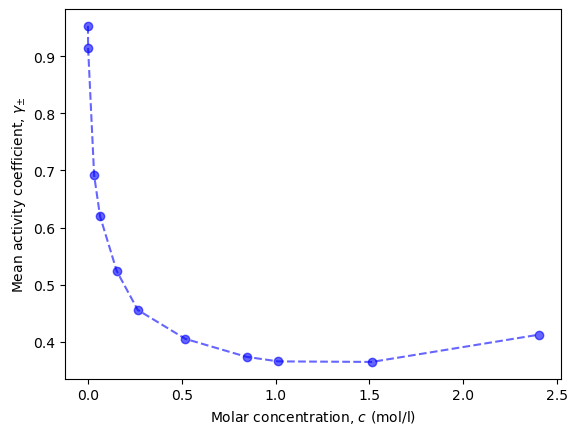

In [4]:
plt.plot(molarity, np.exp(mu_excess), "bo--", alpha=0.6)
plt.xlabel(r"Molar concentration, $c$ (mol/l)")
plt.ylabel(r"Mean activity coefficient, $\gamma_{\pm}$")
plt.show()

## Radial distribution function

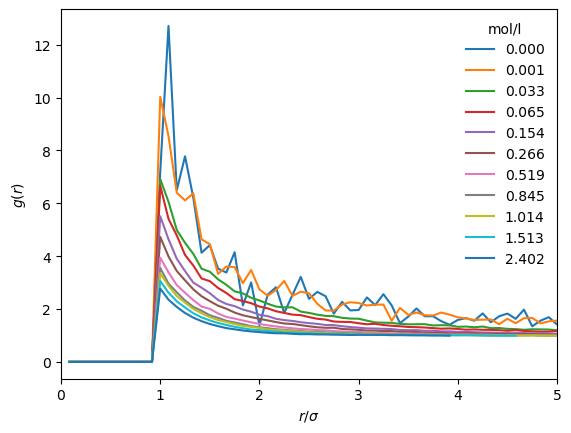

In [5]:
for L in L_range:
    r, g = np.loadtxt(f"rdf{L}.dat", unpack=True)
    sel = r < L / 2
    molarity = N / L**3 * 1e27 / N_A
    s = 0.5 * (sigma[0] + sigma[1])
    plt.plot(r[sel] / s, g[sel], label=f"{molarity:.3f}")
plt.xlim(0, 5)
plt.legend(title="mol/l", frameon=False)
plt.xlabel(r"$r/\sigma$")
plt.ylabel(r"$g(r)$")
plt.show()